In [1]:
#here we are generating a neural style transfer on an image using tensorflow and keras  

%pip install tensorflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model






[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array   
print("all installed")

all installed


In [3]:
#image loading and preprocessing functions
def load_and_process_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image)
    image_array = preprocess_input(image_array)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

In [25]:
def display_image(image_array, show_figure=True):
    if len(image_array.shape) == 4:
        image_array = np.squeeze(image_array, axis=0)

    image_array = deprocess_image(image_array)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_array)
    plt.axis('off')
    if show_figure:
        plt.show()
    return


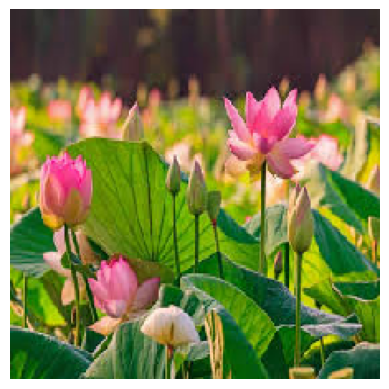

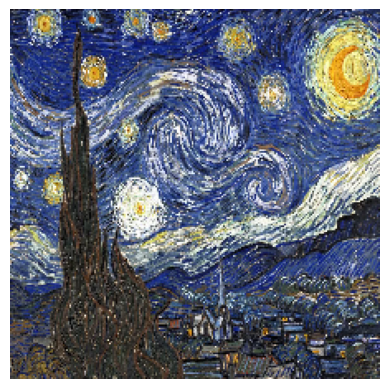

In [55]:
#now display the images
content_image = load_and_process_image('lotus.png')
display_image(content_image)

style_image = load_and_process_image('starrynights.png')
display_image(style_image)

In [6]:
#model setup
model = VGG19(
    include_top=False,
    weights='imagenet'
)
model.trainable = False

model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [7]:
#content model defining
#so noww we are definnig the content and the style models 

content_layer = 'block5_conv2'
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
content_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 15,304,768 (58.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,304,768 (58.38 MB)

In [42]:
#define style model
style_layers = [
    
    
    'block3_conv1',
    
    'block5_conv1'
]

style_models =[Model(
    inputs=model.input,
    outputs=model.get_layer(layer).output
) for layer in style_layers]


In [41]:
#content loss
def content_loss(content, generated):
    a_c = content_model(content)
    a_g = content_model(generated)
    loss = tf.reduce_mean(tf.square(a_c - a_g))
    return loss

In [40]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

weight_of_layer = 1.0 / len(style_models)

In [39]:
def style_loss(style, generated):
    j_style = 0
    for model in style_models:
        a_s = model(style)
        a_g = model(generated)
        gram_s = gram_matrix(a_s)
        gram_g = gram_matrix(a_g)
        current_loss = tf.reduce_mean(tf.square(gram_s - gram_g))
        j_style += weight_of_layer * current_loss
    return j_style


In [38]:
def content_loss(style, generated):
    j_content = 0
    for style_model in style_models:
        a_s = style_model(style)
        a_g = style_model(generated)
        current_loss = tf.reduce_mean(tf.square(a_s - a_g))
        j_content += current_loss

    return j_content

In [49]:
#main training loop
import time

generated_images = []  # Make generated_images global for later use

def training_loop(content_path, style_path, iterations=150, a=0.5, b=10000000):
    global generated_images
    content = load_and_process_image(content_path, target_size=(224, 224))
    style = load_and_process_image(style_path, target_size=(224, 224))
    generated = tf.Variable(content, dtype=tf.float32)
    opt = tf.keras.optimizers.Adam(1.5)

    generated_images = []
    best_cost = math.inf
    best_image = None
    for i in range(iterations):
        start_time_cpu = time.process_time()
        start_time_wall = time.time()
        with tf.GradientTape() as tape:
            j_content = content_loss(content, generated)
            j_style = style_loss(style, generated)
            j_total = a * j_content + b * j_style

        grads = tape.gradient(j_total, generated)
        opt.apply_gradients([(grads, generated)])

        end_time_cpu = time.process_time()  
        end_time_wall = time.time()  
        cpu_time = end_time_cpu - start_time_cpu  
        wall_time = end_time_wall - start_time_wall  

        if j_total < best_cost:
            best_cost = j_total
            best_image = generated.numpy()

        print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
          int(cpu_time * 1e6),
          int(( end_time_cpu - start_time_cpu) * 1e9),
          int((end_time_cpu - start_time_cpu + 1e-6) * 1e6))
             )
        
        print("Wall time: {:.2f} µs".format(wall_time * 1e6))
        print("Iteration :{}".format(i))
        print('Total Loss {:e}.'.format(j_total))
        generated_images.append(generated.numpy())

    return best_image


In [52]:
final_img = training_loop('v.png', 'style3.png')

CPU times: user 16218750 µs, sys: 16218750000 ns, total: 16218751 µs
Wall time: 2549851.18 µs
Iteration :0
Total Loss 9.530928e+16.
CPU times: user 15390625 µs, sys: 15390625000 ns, total: 15390626 µs
Wall time: 2437919.14 µs
Iteration :1
Total Loss 8.939149e+16.
CPU times: user 14921875 µs, sys: 14921875000 ns, total: 14921876 µs
Wall time: 2405883.31 µs
Iteration :2
Total Loss 8.317801e+16.
CPU times: user 14984375 µs, sys: 14984375000 ns, total: 14984376 µs
Wall time: 2416114.81 µs
Iteration :3
Total Loss 7.671961e+16.
CPU times: user 15796875 µs, sys: 15796875000 ns, total: 15796876 µs
Wall time: 2409803.63 µs
Iteration :4
Total Loss 7.009958e+16.
CPU times: user 15156250 µs, sys: 15156250000 ns, total: 15156251 µs
Wall time: 2358270.41 µs
Iteration :5
Total Loss 6.344865e+16.
CPU times: user 16640625 µs, sys: 16640625000 ns, total: 16640626 µs
Wall time: 2316754.58 µs
Iteration :6
Total Loss 5.691700e+16.
CPU times: user 15109375 µs, sys: 15109375000 ns, total: 15109376 µs
Wall ti

<Figure size 1200x1200 with 0 Axes>

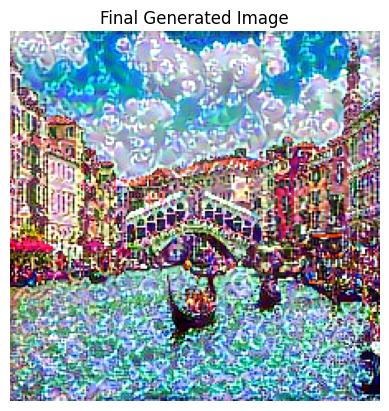

In [54]:
plt.figure(figsize=(12, 12))

 # Use i instead of i+1 to avoid IndexError

plt.show()
plt.title('Final Generated Image')  

display_image(final_img)